Nach dieser [Quelle](https://www.kaggle.com/code/wissams/titanic-competition-step-by-step-using-xgboost)

**Hat auch gute explorative Datenanalyse!**

In [1]:
import pandas as pd
import numpy as np

# Zeige alle Daten, egal wie groß das DF ist
pd.options.display.max_columns = None
pd.options.display.max_rows = None

# Funktionen
def transform_data(df:pd.DataFrame):
    # Fülle die fehlenden Wert in 'Age' auf
    df["Age"] = df["Age"].fillna(df["Age"].mean())
    
    # Fülle fehlende Werte in 'Embarked' auf
    df["Embarked"] = df["Embarked"].fillna("U")
    
    # Fülle fehlende Werte in 'Fare' auf
    df["Fare"] = df["Fare"].fillna(df["Fare"].mean())
    
    # Now the names...
    # First, seperate the first and last name
    df[["LastName", "FirstName_tmp"]] = df["Name"].str.split(",", expand=True)
    
    # Now the salutation forms
    df[["SalutForm","FirstName"]] = df["FirstName_tmp"].str.split(".", n=1, expand=True)
    df["SalutForm"] = df["SalutForm"].str.replace(" ", "")
    title_mapping= {
        "Mr":"Mr",
        "Mrs":"Mrs",
        "Miss":"Miss",
        "Master":"Master",
        "Don":"Rare",
        "Rev":"Rare",
        "Dr":"Rare",
        "Mme":"Mrs",
        "Ms":"Miss",
        "Major":"Rare",
        "Lady":"Rare" ,
        "Sir":"Rare",
        "Mlle":"Miss",
        "Col":"Rare",
        "Capt":"Rare",
        "theCountess":"Rare",
        "Jonkheer":"Rare",
        "Dona":"Rare"
    }
    df["Title"] = df["SalutForm"].map(title_mapping)
    
    # Calc family size
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    
    # Alter gruppieren
    group_limits = [0, 10, 20, 30, 40, 50 , 60, 70, 100]
    groups = ["0-10", "10-20", "20-30", "30-40", "40-50", "50-60", "60-70", "70-100"]
    df["AgeGroup"] = pd.cut(df['Age'], bins=group_limits, labels=groups)
    
    # Kartenkosten gruppieren (min:0, max:512.3292, das sind die Quartilsgrenzen unten)
    group_limits = [-1, 7.9104, 14.4542, 31.0, 70, np.inf]
    groups = ["Low", "Medium", "High", "Extreme", "MoreExtreme"]
    df["FareGroup"] = pd.cut(df['Fare'], bins=group_limits, labels=groups)
    
    # Extrahiere den ersten Buchstaben der Kabine (falls nicht vorhanden -> U)
    # U --> Unknown!
    df["CabinLetter"] = df["Cabin"].str[:1]
    df["CabinLetter"].fillna("U", inplace=True)
    
    # Erstelle die Spalte "IsMale", um unnötiges OHE zu vermeiden
    df["IsMale"]= df["Sex"].apply(lambda x: 1 if x=="male" else 0)
    
    # Ermittle die Gruppengröße (Wie viele Passagiere haben diesselbe Ticketnummer?)
    tickets= df.groupby(["Ticket"])[["PassengerId"]].count().rename(columns={"PassengerId": "Count"})
    df["GroupSize"]=df["Ticket"].apply(lambda x: tickets.loc[x, "Count"])
    
    # Erstelle ein paar Interaktionsvariablen
    df["Class+Sex"] = df["Pclass"].astype(str) + "+" + df["Sex"].astype(str)
    df["AgeGroup+Sex"] = df["AgeGroup"].astype(str) + "+" + df["Sex"].astype(str)
    df["AgeGroup+Class"] = df["AgeGroup"].astype(str) + "+" + df["Pclass"].astype(str)
    df["Embarked+Class"] = df["Embarked"].astype(str) + "+" + df["Pclass"].astype(str)
    df["Title+Class"] = df["Title"].astype(str) + "+" + df["Pclass"].astype(str)
    df["FareGroup+Sex"] = df["FareGroup"].astype(str) + "+" + df["Sex"].astype(str)

    # Verwerfe nicht benötigte Zeilen
    df = df.drop([
        "PassengerId",
        "FirstName_tmp",
        "Name",
        "Cabin",
        "SibSp",
        "Parch",
        "FirstName",
        "Sex",
        "Ticket",
        "SalutForm"],
        axis=1)
                              
    return df

def group_families_fam_size(df: pd.DataFrame):
    for fam in df["LastName"].unique():
        tmp_df = df.loc[df["LastName"] == fam ]
        
        unique_fam_sizes = tmp_df["FamilySize"].unique()
        
        i = 0
        for size in unique_fam_sizes:
            df.loc[(df["FamilySize"] == size) & (df["LastName"] == fam), "Family"] = f"{fam}_{i}"
            i = i + 1 

In [2]:
from sklearn import compose, impute, linear_model, preprocessing
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

def prepare_data():

    # Lade den Trainingsdatensatz
    train = pd.read_csv("../data/train.csv")
    train["IsKaggleTestData"] = False
    
    # Lade den Kaggle Test Datensatz
    # Dieser muss zusammen mit dem Trainingsdatensatz verarbeitet werden, sonst fehlen einige Spalten im Kaggle Testdatensatz!
    X_test_kaggle = pd.read_csv("../data/test.csv")
    _X_test_kaggle = X_test_kaggle.copy()

    X_test_kaggle["Survived"] = 0 # Dummy damit Pandas keine Zicken macht
    X_test_kaggle["IsKaggleTestData"] = True
    
    # Kombiniere beide Datensätze, da es ansonsten Probleme mit der Pipeline gibt
    df = pd.concat([train, X_test_kaggle], axis=0)
    
    # Transformiere die Daten mit der ersten Funktion
    df = transform_data(df)
    group_families_fam_size(df)
    df_for_exploration = df.copy()
    
    # Typisiere die Spalten
    num_cols = ["Age", "Fare", "FamilySize"]
    cat_cols = [
        "Pclass",
        "Embarked",
        "Title",
        "FareGroup",
        "CabinLetter",
        "AgeGroup",
        "Class+Sex",
        "AgeGroup+Sex",
        "AgeGroup+Class",
        "Embarked+Class",
        "Title+Class",
        "FareGroup+Sex"
    ]
    dist_col = ["IsKaggleTestData", "IsMale"]
    
    # Definiere die Pipeline und die verschiedenen Preprocesors
    numerical_preprocessor = Pipeline(steps=[
        ("imputer", impute.SimpleImputer(strategy="mean")),
        ("scaler", preprocessing.StandardScaler())
    ])

    categorical_preprocessor = Pipeline(steps=[
        ("imputer", impute.SimpleImputer(strategy="most_frequent")),
        ("onehot", preprocessing.OneHotEncoder(handle_unknown="error", sparse_output=False)),
    ])

    preprocessor = compose.ColumnTransformer(
        transformers=[
            ("numerical", numerical_preprocessor, num_cols),
            ("categorical", categorical_preprocessor, cat_cols),
            ("passthrough", "passthrough", dist_col)
        ]
    )
    
    # Löse die Labels von Features ab
    y = df[["Survived","IsKaggleTestData"]]
    X = df.drop(["Survived"], axis=1)
    
    # Preprocess die Features
    preprocessor.set_output(transform="pandas")
    X_pipe = preprocessor.fit_transform(X)
    
    # Löse die Kaggle Testdaten von der Gesamtheit der Features und bereinige diese von der Dummy Spalte
    X_test_kaggle_pipe = X_pipe.loc[X_pipe["passthrough__IsKaggleTestData"] == True]
    X_test_kaggle_pipe = X_test_kaggle_pipe.drop(["passthrough__IsKaggleTestData"], axis = 1)
    
    # Löse die Trainingsfeatures von der Gesamtheit der Features und bereinige diese von der Dummy Spalte
    X_train_full_pipe = X_pipe.loc[X_pipe["passthrough__IsKaggleTestData"] == False]
    X_train_full_pipe = X_train_full_pipe.drop(["passthrough__IsKaggleTestData"], axis = 1)
    
    # Trenne die Trainingslabels von den Dummy Labels
    y_train_full_pipe = y.loc[y["IsKaggleTestData"] == False]
    y_train_full_pipe = y_train_full_pipe.drop(["IsKaggleTestData"], axis = 1)
    
    # Erstelle aus den Trainingsfeatures ein weiteren Testdatensatz, der lokal benutzt wird
    X_train, X_test, y_train, y_test = train_test_split(X_train_full_pipe, y_train_full_pipe, test_size=0.2)
    
    # Gebe die lokalen Trainings- und Testdatensätze sowie den Kaggle Testdatensatz zurück
    return X_train, X_test, y_train, y_test, X_test_kaggle_pipe, _X_test_kaggle, df_for_exploration

In [3]:
X_train, X_test, y_train, y_test, X_test_kaggle_pipe, _X_test_kaggle, df_data_ex = prepare_data()

In [4]:
df_data_ex = df_data_ex.loc[df_data_ex["IsKaggleTestData"] == False]
df_data_ex = df_data_ex.drop(["IsKaggleTestData"], axis = 1)

In [5]:
df_data_ex.head()

,Survived,Pclass,Age,Fare,Embarked,LastName,Title,FamilySize,AgeGroup,FareGroup,CabinLetter,IsMale,GroupSize,Class+Sex,AgeGroup+Sex,AgeGroup+Class,Embarked+Class,Title+Class,FareGroup+Sex,Family
0,0,3,22.0,7.2500,S,Braund,Mr,2,20-30,Low,U,1,1,3+male,20-30+male,20-30+3,S+3,Mr+3,Low+male,Braund_0
1,1,1,38.0,71.2833,C,Cumings,Mrs,2,30-40,MoreExtreme,C,0,2,1+female,30-40+female,30-40+1,C+1,Mrs+1,MoreExtreme+female,Cumings_0
2,1,3,26.0,7.9250,S,Heikkinen,Miss,1,20-30,Medium,U,0,1,3+female,20-30+female,20-30+3,S+3,Miss+3,Medium+female,Heikkinen_0
3,1,1,35.0,53.1000,S,Futrelle,Mrs,2,30-40,Extreme,C,0,2,1+female,30-40+female,30-40+1,S+1,Mrs+1,Extreme+female,Futrelle_0
4,0,3,35.0,8.0500,S,Allen,Mr,1,30-40,Medium,U,1,1,3+male,30-40+male,30-40+3,S+3,Mr+3,Medium+male,Allen_0


In [6]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 434 to 280
Columns: 117 entries, numerical__Age to passthrough__IsMale
dtypes: float64(116), int64(1)
memory usage: 656.4 KB


In [7]:
X_train.shape

(712, 117)

In [8]:
df_data_ex["Embarked+Class"].value_counts()

S+3    353
S+2    164
S+1    127
C+1     85
Q+3     72
C+3     66
C+2     17
Q+2      3
U+1      2
Q+1      2
Name: Embarked+Class, dtype: int64

<Axes: >

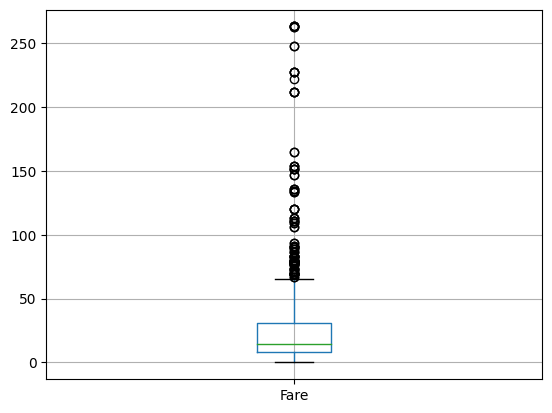

In [9]:
df_data_ex[df_data_ex["Fare"] < 500].boxplot(["Fare"])

In [10]:
df_data_ex.boxplot(["Fare"])

<Axes: >

In [11]:
df_data_ex["FareGroup"].value_counts()

Medium         224
Low            223
High           222
Extreme        117
MoreExtreme    105
Name: FareGroup, dtype: int64

In [12]:
df_data_ex["Fare"].max()

512.3292

In [13]:
# Finde heraus, welche Spalten wenige Passagiere erfassen und lösche diese (sonst könnte es zu Overfitting kommen)
cols_to_drop = []
for col in X_train.columns:
    if "categorical__" in col:
        if X_train[col].sum()/len(X_train) < 0.1:
            cols_to_drop.append(col)
print(cols_to_drop)

X_train = X_train.drop(cols_to_drop, axis=1)
X_test = X_test.drop(cols_to_drop, axis=1)
X_test_kaggle_pipe = X_test_kaggle_pipe.drop(cols_to_drop, axis=1)

['categorical__Embarked_Q', 'categorical__Embarked_U', 'categorical__Title_Master', 'categorical__Title_Rare', 'categorical__CabinLetter_A', 'categorical__CabinLetter_B', 'categorical__CabinLetter_C', 'categorical__CabinLetter_D', 'categorical__CabinLetter_E', 'categorical__CabinLetter_F', 'categorical__CabinLetter_G', 'categorical__CabinLetter_T', 'categorical__AgeGroup_0-10', 'categorical__AgeGroup_40-50', 'categorical__AgeGroup_50-60', 'categorical__AgeGroup_60-70', 'categorical__AgeGroup_70-100', 'categorical__Class+Sex_2+female', 'categorical__AgeGroup+Sex_0-10+female', 'categorical__AgeGroup+Sex_0-10+male', 'categorical__AgeGroup+Sex_10-20+female', 'categorical__AgeGroup+Sex_10-20+male', 'categorical__AgeGroup+Sex_30-40+female', 'categorical__AgeGroup+Sex_40-50+female', 'categorical__AgeGroup+Sex_40-50+male', 'categorical__AgeGroup+Sex_50-60+female', 'categorical__AgeGroup+Sex_50-60+male', 'categorical__AgeGroup+Sex_60-70+female', 'categorical__AgeGroup+Sex_60-70+male', 'categori

In [14]:
# raise Exception("STOOOOOOP")


In [15]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

In [16]:
# Hyperparameter für die Modelle

# Random Forest
rf_params = {
    "n_jobs": -1,
    "n_estimators": 500,
     "warm_start": True, 
     #"max_features": 0.2,
    "max_depth": 6,
    "min_samples_leaf": 2,
    "max_features" : "sqrt",
    "verbose": 0
}

# Extra Trees
et_params = {
    "n_jobs": -1,
    "n_estimators":500,
    # "max_features": 0.5,
    "max_depth": 8,
    "min_samples_leaf": 2,
    "verbose": 0
}

# AdaBoost
ada_params = {
    "n_estimators": 500,
    "learning_rate" : 0.75
}

# Gradient Boosting
gb_params = {
    "n_estimators": 500,
    # "max_features": 0.2,
    "max_depth": 5,
    "min_samples_leaf": 2,
    "verbose": 0
}

# Support Vector Classifier
svc_params = {
    "kernel" : "linear",
    "C" : 0.025
}

bag_svc_params = {
    "estimator": SVC(),
    "n_estimators": 500,
    "max_samples": 50,
    "bootstrap": True,
    "n_jobs": -1
}

bag_rf_params = {
    "estimator": RandomForestClassifier(),
    "n_estimators": 100,
    "max_samples": 200,
    "bootstrap": True,
    "n_jobs": -1
}

bag_dt_params = {
    "estimator": DecisionTreeClassifier(),
    "n_estimators": 100,
    "max_samples": 200,
    "bootstrap": True,
    "n_jobs": -1
}

# für die Grid Search (siehe weiter unten)
param_grid = {
    "n_estimators": [100, 200, 300],
    "max_samples": [100, 200, 300],
    "bootstrap": [False, True]
}

In [17]:
# Create 5 objects that represent our 4 models
rf = RandomForestClassifier(**rf_params)
et = ExtraTreesClassifier(**et_params)
ada = AdaBoostClassifier(**ada_params)
gb = GradientBoostingClassifier(**gb_params)
svc = SVC(**svc_params)
bag_svc = BaggingClassifier(**bag_svc_params)
bag_rf = BaggingClassifier(**bag_rf_params)
bag_dt = BaggingClassifier(**bag_dt_params)

In [18]:
# Grid Search
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(
    estimator=bag_dt,
    param_grid=param_grid,
    cv=10,
    verbose=1,
    scoring="accuracy"
)

In [19]:
models = {
    "RandomForest": rf,
    "ExtraTrees": et,
    "AdaBoost": ada,
    "GradientBoosting": gb,
    "SVC": svc,
    "Bagging_SVC": bag_svc,
    "Bagging_RandomForest": bag_rf,
    "Bagging_DecisionTree": bag_dt,
    "GridSearchBest": grid_search,
}

In [20]:
# Trainiere sie alle
for model in models.values():
    model.fit(X_train, y_train.to_numpy().ravel())

Fitting 10 folds for each of 18 candidates, totalling 180 fits


In [21]:
# Ersetze die Grid Search durch das beste Modell
models["GridSearchBest"] = grid_search.best_estimator_
print("Beste Parameter:", grid_search.best_params_)

Beste Parameter: {'bootstrap': True, 'max_samples': 200, 'n_estimators': 100}


In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from datetime import datetime

result_text = ""
for name, model in models.items():
    result = cross_val_score(model, X_train, y_train.to_numpy().ravel(), scoring="accuracy")
    mean = sum(result) / len(result)
    y_test_predict = model.predict(X_test)

    
    string = f"Modell: {name}"
    string = f"{string}\nDurc. Accuracy: {mean} (cross val. auf Trainingsdatensatz)"
    string = f"{string}\nAccuracy: \t{accuracy_score(y_test, y_test_predict)} (Testdatensatz)"
    string = f"{string}\nPrecision: \t{precision_score(y_test, y_test_predict)} (Testdatensatz)"
    string = f"{string}\nRecall: \t{recall_score(y_test, y_test_predict)} (Testdatensatz)"
    string = f"{string}\nF1 Score: \t{f1_score(y_test, y_test_predict)} (Testdatensatz)"
    print(string, "\n")
    result_text = f"{result_text}\n{string}\n"
    
with open(f"../submissions/{datetime.today().strftime('%Y-%m-%d %H_%M_%S')}_last values.txt", "w") as file:
    file.write(result_text)
    file.close()


Modell: RandomForest
Durc. Accuracy: 0.8455825864276569 (cross val. auf Trainingsdatensatz)
Accuracy: 	0.776536312849162 (Testdatensatz)
Precision: 	0.803921568627451 (Testdatensatz)
Recall: 	0.5774647887323944 (Testdatensatz)
F1 Score: 	0.6721311475409837 (Testdatensatz) 

Modell: ExtraTrees
Durc. Accuracy: 0.8357431301093273 (cross val. auf Trainingsdatensatz)
Accuracy: 	0.770949720670391 (Testdatensatz)
Precision: 	0.8 (Testdatensatz)
Recall: 	0.5633802816901409 (Testdatensatz)
F1 Score: 	0.6611570247933886 (Testdatensatz) 

Modell: AdaBoost
Durc. Accuracy: 0.8258642765685019 (cross val. auf Trainingsdatensatz)
Accuracy: 	0.8156424581005587 (Testdatensatz)
Precision: 	0.88 (Testdatensatz)
Recall: 	0.6197183098591549 (Testdatensatz)
F1 Score: 	0.7272727272727273 (Testdatensatz) 

Modell: GradientBoosting
Durc. Accuracy: 0.8329459273121245 (cross val. auf Trainingsdatensatz)
Accuracy: 	0.7932960893854749 (Testdatensatz)
Precision: 	0.7931034482758621 (Testdatensatz)
Recall: 	0.6478873

In [26]:
# Vorhersagen für Kaggle

name = "RandomForest"

# Check, ob der Name im Dict ist
if name not in models.keys():
    raise KeyError(f"Das Modell {name} ist nicht im Dictionary!")


preds_kaggle = models[name].predict(X_test_kaggle_pipe)
output = pd.DataFrame({"PassengerId": _X_test_kaggle["PassengerId"], "Survived": preds_kaggle})
output_path = f"../submissions/{datetime.today().strftime('%Y-%m-%d %H_%M_%S')} {name}.csv"
output.to_csv(output_path, index=False)